# Configuration

In [7]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [8]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [9]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 667.20it/s]


In [10]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [11]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [12]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [13]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [14]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [15]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [16]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [17]:
RAV_train = []
RAV_val = []
RAV_test = []

In [18]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [19]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [20]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [21]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [22]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
fear         60
surprise     60
happy        60
sadness      60
disgust      60
angry        60
Name: emotion_label, dtype: int64

In [23]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [24]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [25]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [26]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [27]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [28]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [29]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
surprise     800
disgust      800
fear         800
sadness      800
neutral      800
happy        400
Name: emotion_label, dtype: int64

In [30]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [31]:
TESS_train = []
TESS_test = []

In [32]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [33]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [34]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [35]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [36]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [37]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [38]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [39]:
Crema_df.shape

(455, 4)

In [40]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [41]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [42]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [43]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [44]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [45]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [46]:
CREMA_df = pd.DataFrame(new_df)

In [47]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [48]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [49]:
count_males, count_females

(220, 220)

In [50]:
len(female_list)

44

In [51]:
len(male_list)

44

In [52]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [53]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [54]:
females_train, males_train, females_val, males_val, females_test, males_test

(['89',
  '60',
  '74',
  '76',
  '08',
  '56',
  '43',
  '82',
  '30',
  '47',
  '55',
  '09',
  '28',
  '58',
  '13',
  '40',
  '91',
  '49',
  '73',
  '07',
  '04',
  '61',
  '78',
  '84',
  '53',
  '02',
  '79',
  '63',
  '03',
  '54',
  '06',
  '29'],
 ['83',
  '38',
  '65',
  '67',
  '45',
  '70',
  '48',
  '87',
  '15',
  '35',
  '31',
  '69',
  '57',
  '42',
  '44',
  '62',
  '86',
  '50',
  '33',
  '41',
  '36',
  '22',
  '68',
  '23',
  '27',
  '19',
  '39',
  '64',
  '59',
  '66',
  '11',
  '01'],
 ['72', '20', '10', '18', '46', '21'],
 ['32', '34', '51', '85', '05', '71'],
 ['24', '75', '52', '37', '12', '25'],
 ['77', '26', '16', '14', '81', '90'])

In [55]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [56]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [57]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [58]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [59]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [60]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 

# Create Validation Datasets Ensemble

- validation_dataset_1 = RAVDESS_clean_val + RAVDESS_clean_test 
- validation_dataset_2 = all_clean_val + all_clean_test

In [61]:
validation_dataset_1 = pd.concat([RAV_val, RAV_test], ignore_index=True, sort=False)

In [62]:
validation_dataset_1

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
235,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
236,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
237,angry,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
238,surprise,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [63]:
validation_dataset_2 = pd.concat([RAV_val, RAV_test, 
                                    SAVEE_val, SAVEE_test, 
                                    TESS_test, 
                                    CREMA_val, CREMA_test], ignore_index=True, sort=False)

In [64]:
validation_dataset_2

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
1995,sadness,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1996,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1997,disgust,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1998,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


# Encode labels of Validation Datasets

In [65]:
labels_1 = list(validation_dataset_1.emotion_label)
labels_2 = list(validation_dataset_2.emotion_label)

In [66]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels_1 = pd.Series(labels_1).replace(emotion_enc)
labels_2 = pd.Series(labels_2).replace(emotion_enc)

# Utils Validation Ensemble

In [67]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [68]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [69]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [70]:
#!pip install scikit-learn==0.24.2

In [71]:
#!jupyter nbextension enable --py widgetsnbextension

In [72]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [73]:
def make_predictions(dataset, labels, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        print("True label", labels[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))
    

    
    
    

# Validation 1 - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [74]:
predictions, model_prediction_list = make_predictions(validation_dataset_1, labels_1, prediction_scheme='avg_pred')

  0%|          | 1/240 [00:21<1:26:34, 21.73s/it]

[0.21641621, 0.5239922, 0.58158255, 0.30858582, 0.6508572, 0.041726768, 0.04238221, 0.4568143, 0.14644936, 0.83928454, 0.051340163, 0.15365446, 0.5220866, 0.76291114, 1, 1, 0, 0, 1]
pred conv [0.21641621, 0.5239922, 0.58158255, 0.30858582, 0.6508572, 0.041726768, 0.04238221, 0.4568143, 0.14644936, 0.83928454, 0.051340163, 0.15365446, 0.5220866, 0.76291114] pred svm [1, 1, 0, 0, 1, 0.37843453671251026] avg_prediction_conv 0.37843453671251026 new pred [1, 1, 0, 0, 1, 0.37843453671251026]
True label 0 Predicted label 1


  1%|          | 2/240 [00:39<1:21:56, 20.66s/it]

[0.23881468, 0.23238978, 0.47837257, 0.1241442, 0.22217038, 0.037085086, 0.43766502, 0.14850745, 0.12050754, 0.8437903, 0.008586615, 0.108226925, 0.49480218, 0.37511432, 1, 0, 0, 0, 0]
pred conv [0.23881468, 0.23238978, 0.47837257, 0.1241442, 0.22217038, 0.037085086, 0.43766502, 0.14850745, 0.12050754, 0.8437903, 0.008586615, 0.108226925, 0.49480218, 0.37511432] pred svm [1, 0, 0, 0, 0, 0.27644121646881104] avg_prediction_conv 0.27644121646881104 new pred [1, 0, 0, 0, 0, 0.27644121646881104]
True label 0 Predicted label 0


  1%|▏         | 3/240 [00:56<1:16:51, 19.46s/it]

[0.8773644, 0.53234464, 0.6920152, 0.54796445, 0.61923593, 0.39383936, 0.071415395, 0.62995994, 0.33759505, 0.7763002, 0.30539095, 0.26301914, 0.4674505, 0.93526584, 1, 1, 0, 0, 0]
pred conv [0.8773644, 0.53234464, 0.6920152, 0.54796445, 0.61923593, 0.39383936, 0.071415395, 0.62995994, 0.33759505, 0.7763002, 0.30539095, 0.26301914, 0.4674505, 0.93526584] pred svm [1, 1, 0, 0, 0, 0.5320829259497779] avg_prediction_conv 0.5320829259497779 new pred [1, 1, 0, 0, 0, 0.5320829259497779]
True label 1 Predicted label 0


  2%|▏         | 4/240 [01:14<1:14:25, 18.92s/it]

[0.9998362, 0.968698, 0.91645896, 0.99755514, 0.87495863, 0.99896526, 0.38121837, 0.99931574, 0.9966487, 0.942219, 0.99973285, 0.9604449, 0.52000153, 0.9981333, 0, 1, 0, 1, 0]
pred conv [0.9998362, 0.968698, 0.91645896, 0.99755514, 0.87495863, 0.99896526, 0.38121837, 0.99931574, 0.9966487, 0.942219, 0.99973285, 0.9604449, 0.52000153, 0.9981333] pred svm [0, 1, 0, 1, 0, 0.8967276215553284] avg_prediction_conv 0.8967276215553284 new pred [0, 1, 0, 1, 0, 0.8967276215553284]
True label 1 Predicted label 0


  2%|▏         | 5/240 [01:32<1:13:42, 18.82s/it]

[0.9999989, 0.8537375, 0.8035034, 0.99833333, 0.74785537, 0.99710554, 0.43392307, 0.99758154, 0.9980047, 0.8524585, 0.99822825, 0.93465877, 0.500275, 0.95345104, 0, 1, 0, 1, 0]
pred conv [0.9999989, 0.8537375, 0.8035034, 0.99833333, 0.74785537, 0.99710554, 0.43392307, 0.99758154, 0.9980047, 0.8524585, 0.99822825, 0.93465877, 0.500275, 0.95345104] pred svm [0, 1, 0, 1, 0, 0.862079633133752] avg_prediction_conv 0.862079633133752 new pred [0, 1, 0, 1, 0, 0.862079633133752]
True label 1 Predicted label 0


  2%|▎         | 6/240 [01:53<1:15:35, 19.38s/it]

[0.875298, 0.6432744, 0.5637859, 0.5581343, 0.64597964, 0.6435024, 0.18371856, 0.6877435, 0.9017129, 0.42770544, 0.75098974, 0.5068263, 0.5078153, 0.8467647, 0, 1, 0, 0, 0]
pred conv [0.875298, 0.6432744, 0.5637859, 0.5581343, 0.64597964, 0.6435024, 0.18371856, 0.6877435, 0.9017129, 0.42770544, 0.75098974, 0.5068263, 0.5078153, 0.8467647] pred svm [0, 1, 0, 0, 0, 0.6245179367916924] avg_prediction_conv 0.6245179367916924 new pred [0, 1, 0, 0, 0, 0.6245179367916924]
True label 1 Predicted label 0


  3%|▎         | 7/240 [02:13<1:16:33, 19.71s/it]

[0.09932616, 0.1290468, 0.3864693, 0.5416309, 0.37028164, 0.70037454, 0.7512245, 0.31902233, 0.3363034, 0.7805269, 0.1565915, 0.36729842, 0.44491675, 0.55312234, 1, 0, 0, 0, 1]
pred conv [0.09932616, 0.1290468, 0.3864693, 0.5416309, 0.37028164, 0.70037454, 0.7512245, 0.31902233, 0.3363034, 0.7805269, 0.1565915, 0.36729842, 0.44491675, 0.55312234] pred svm [1, 0, 0, 0, 1, 0.42400968074798584] avg_prediction_conv 0.42400968074798584 new pred [1, 0, 0, 0, 1, 0.42400968074798584]
True label 1 Predicted label 0


  3%|▎         | 8/240 [02:35<1:18:23, 20.27s/it]

[0.29147953, 0.35309082, 0.7915098, 0.3572646, 0.6096548, 0.4179651, 0.6114118, 0.91789085, 0.5172618, 0.8075999, 0.077617526, 0.16500932, 0.47724432, 0.9611747, 0, 1, 0, 0, 0]
pred conv [0.29147953, 0.35309082, 0.7915098, 0.3572646, 0.6096548, 0.4179651, 0.6114118, 0.91789085, 0.5172618, 0.8075999, 0.077617526, 0.16500932, 0.47724432, 0.9611747] pred svm [0, 1, 0, 0, 0, 0.5254410654306412] avg_prediction_conv 0.5254410654306412 new pred [0, 1, 0, 0, 0, 0.5254410654306412]
True label 1 Predicted label 0


  4%|▍         | 9/240 [03:12<1:37:18, 25.28s/it]

[0.9999833, 0.9632569, 0.65962887, 0.9987427, 0.97985405, 0.991269, 0.23816392, 0.999863, 0.9839262, 0.71100813, 0.9999816, 0.7604708, 0.4767112, 0.99934244, 0, 0, 0, 0, 0]
pred conv [0.9999833, 0.9632569, 0.65962887, 0.9987427, 0.97985405, 0.991269, 0.23816392, 0.999863, 0.9839262, 0.71100813, 0.9999816, 0.7604708, 0.4767112, 0.99934244] pred svm [0, 0, 0, 0, 0, 0.840157293847629] avg_prediction_conv 0.840157293847629 new pred [0, 0, 0, 0, 0, 0.840157293847629]
True label 1 Predicted label 0


  4%|▍         | 10/240 [03:33<1:31:49, 23.96s/it]

[0.89383864, 0.27684343, 0.49508628, 0.8727783, 0.6761825, 0.5223466, 0.086230814, 0.9241447, 0.72793573, 0.61534613, 0.9316283, 0.18844497, 0.46786433, 0.7138615, 0, 1, 0, 0, 0]
pred conv [0.89383864, 0.27684343, 0.49508628, 0.8727783, 0.6761825, 0.5223466, 0.086230814, 0.9241447, 0.72793573, 0.61534613, 0.9316283, 0.18844497, 0.46786433, 0.7138615] pred svm [0, 1, 0, 0, 0, 0.5994665899447033] avg_prediction_conv 0.5994665899447033 new pred [0, 1, 0, 0, 0, 0.5994665899447033]
True label 1 Predicted label 0


  4%|▍         | 10/240 [03:47<1:27:04, 22.72s/it]


KeyboardInterrupt: 

In [ ]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_1, df_predictions, df_model_predictions, validation_dataset_1)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

In [ ]:
print_hist_models_predictions_fp(df_fp)

In [ ]:
print_hist_models_predictions_fn(df_fn)

In [ ]:
print(classification_report(df_res.true_label, df_res.pred_label))

In [ ]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_validation_1_threshold_0_7.csv"
df_res.to_csv(csv_path)

# Validation 2 - ALL DATASETS

We use the same code of the main.py of the real application, without VAD module

In [ ]:
predictions, model_prediction_list = make_predictions(validation_dataset_2, labels_2, prediction_scheme='avg_pred')

In [ ]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_2, df_predictions, df_model_predictions, validation_dataset_1)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

In [ ]:
print_hist_models_predictions_fp(df_fp)

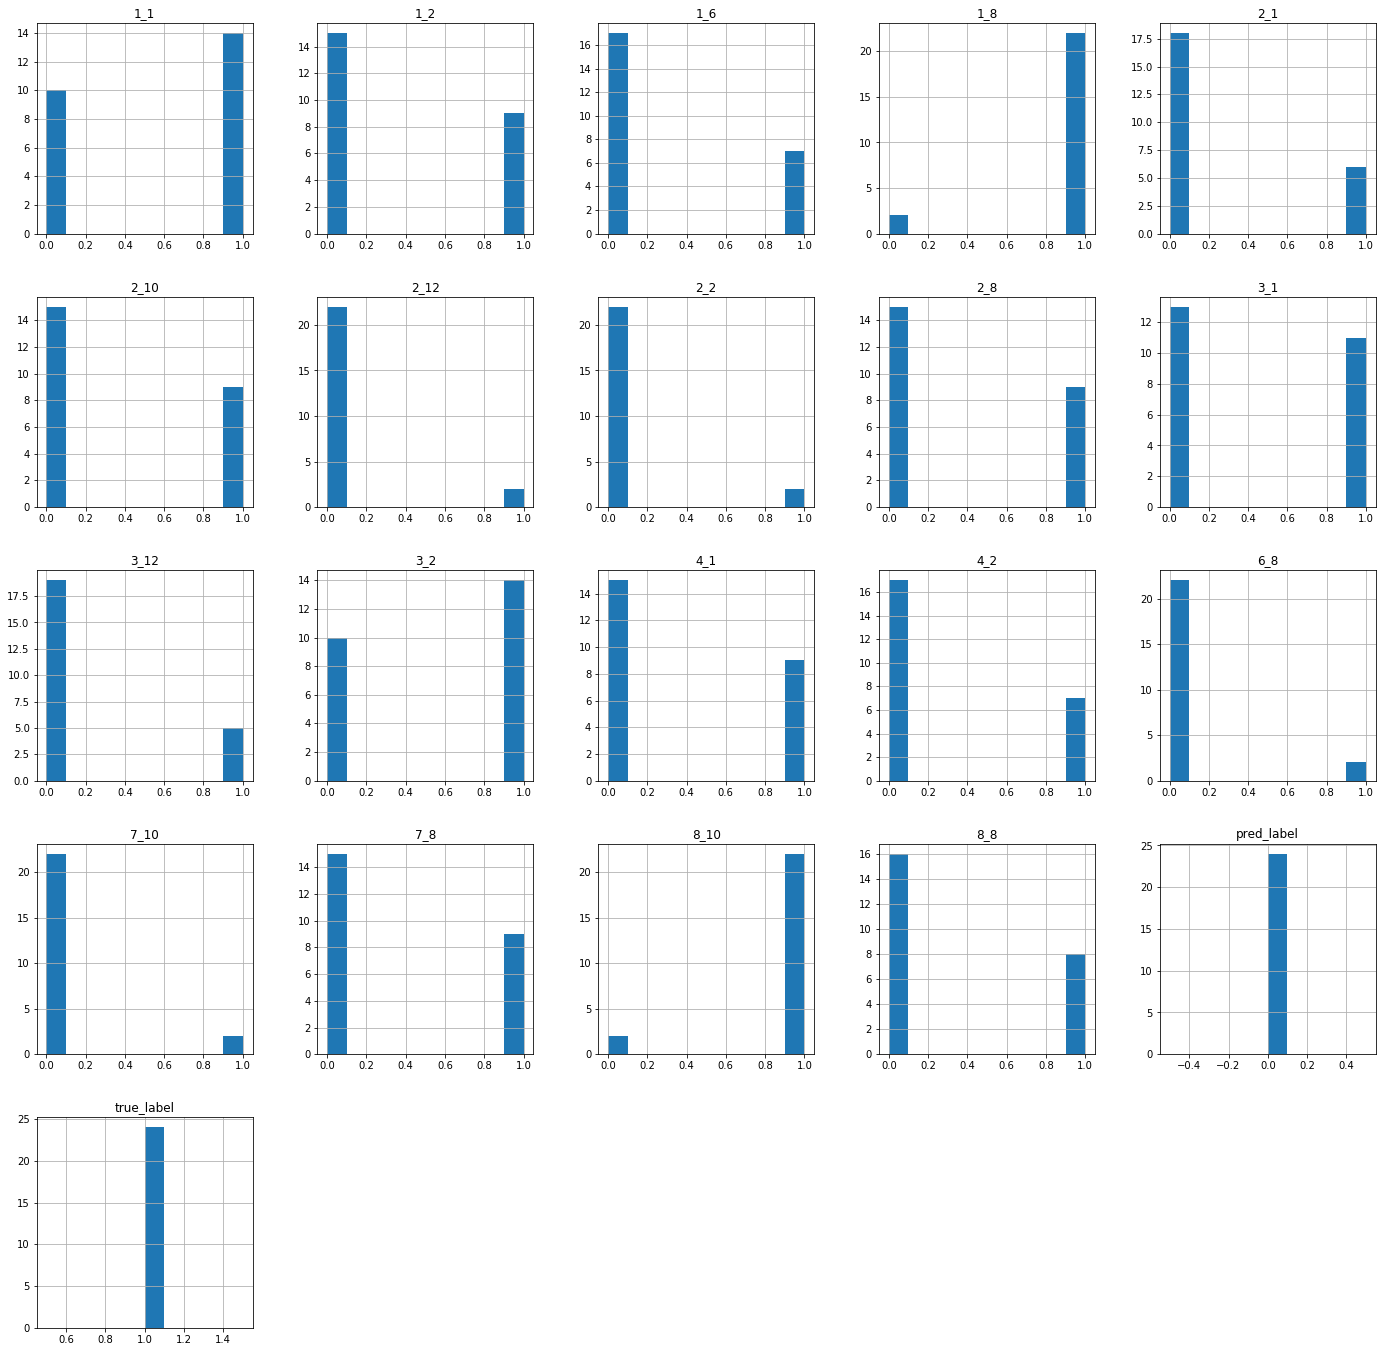

In [84]:
print_hist_models_predictions_fn(df_fn)

In [81]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       112
           1       0.90      0.81      0.85       128

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



In [82]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_validation_2_threshold_0_7.csv"
df_res.to_csv(csv_path)